In [1]:
import pandas as pd
from requests import post
import json
import pickle
%matplotlib inline

In [2]:
df = pd.read_csv("Datasets/dialect_dataset.csv")
df['id'] = df.id.astype(str) 


In [3]:
url = "https://recruitment.aimtechnologies.co/ai-tasks"

tweets = pd.DataFrame()
for i in range(0, df.shape[0], 1000):
    
    print(f"Number of remaining rows is {df.shape[0] - i}") # FOR DEBUGGING
    response = post(url,
                    data= json.dumps(df.id[i: i+1000].values.tolist()))
    
    response = json.loads(response.content.decode('utf-8'))
    d = pd.DataFrame(list(response.items()),
                     columns = ['id', 'tweet'])
    tweets = tweets.append(d,
                       ignore_index=True)


Number of remaining rows is 458197
Number of remaining rows is 457197
Number of remaining rows is 456197
Number of remaining rows is 455197
Number of remaining rows is 454197
Number of remaining rows is 453197
Number of remaining rows is 452197
Number of remaining rows is 451197
Number of remaining rows is 450197
Number of remaining rows is 449197
Number of remaining rows is 448197
Number of remaining rows is 447197
Number of remaining rows is 446197
Number of remaining rows is 445197
Number of remaining rows is 444197
Number of remaining rows is 443197
Number of remaining rows is 442197
Number of remaining rows is 441197
Number of remaining rows is 440197
Number of remaining rows is 439197
Number of remaining rows is 438197
Number of remaining rows is 437197
Number of remaining rows is 436197
Number of remaining rows is 435197
Number of remaining rows is 434197
Number of remaining rows is 433197
Number of remaining rows is 432197
Number of remaining rows is 431197
Number of remaining 

In [4]:
tweets.tail() 

,id,tweet
458192,1019484980282580992,@Al_mhbaa_7 مبسوطين منك اللي باسطانا😅
458193,1021083283709407232,@Zzainabali @P_ameerah والله ماينده ابش يختي
458194,1017477537889431552,@Al_mhbaa_7 شو عملنا لك حنا تهربي مننا احنا مس...
458195,1022430374696239232,@haneenalmwla الله يبارك فيها وبالعافيه 😋😋😋
458196,1022409931029458944,@jolnar121 السحله ضيفي ي بتطلع لك سحليه😅😅


In [5]:
tweets = pd.merge(tweets, df, on ='id', how='right')
tweets.describe()

,id,tweet,dialect
count,458197,458197,458197
unique,458197,458197,18
top,985210217427357568,تمثلني 😂\nخاصة الناس الي ما بدي ياهم وبيقعدوا ...,EG
freq,1,1,57636


In [6]:
fname = 'Datasets/tweets.pkl'
with open(fname, 'wb') as file:
    pickle.dump(tweets, file)


## 01 Data Preprocessing

<AxesSubplot:>

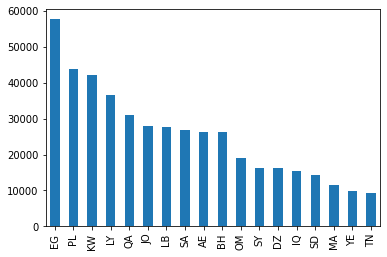

In [7]:
# check balancing data
tweets.dialect.value_counts().plot(kind='bar')

### Dealing with imbalanced data

In [9]:
#using undersampling 
# Store Tunisian records
TN_records = tweets[tweets.dialect == 'TN'].dialect.count()

# Picking the indices of all dialects
dialect_dict = {
    d : tweets.dialect[tweets.dialect == d].index for d in tweets.dialect.unique()
 }



In [11]:
import numpy as np

# Out of the indices we picked, randomly select number of dialects records = number of TN dialect records 
for dialect, indices in dialect_dict.items():
    dialect_dict[dialect] = np.random.choice(indices, TN_records)
    dialect_dict[dialect] = np.array(dialect_dict[dialect])

under_sample_indices = np.concatenate(list(dialect_dict.values()))
# Copy under sample dataset  
under_sampled_data = tweets.iloc[under_sample_indices,:]


<AxesSubplot:>

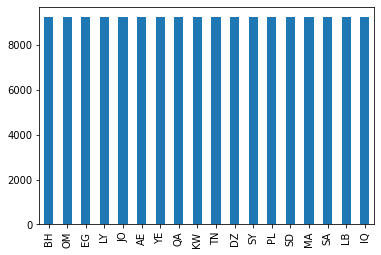

In [12]:
# check data after sampling 
under_sampled_data.dialect.value_counts().plot(kind='bar')

## Cleaning the data

as we working on arabic tweets and our task is to detect/classify the dialect of tweets. so, we are mostly interested in the tweets itself without the mentions of the users or emojis. the cleaning steps will be
1. remove English letters
2. remove punctuation
3. remove numbers
4. and remove special characters

In [13]:
import re

def clean_text(text):
    special_ch = re.compile('[-\+!~@#$%^&*()={}\[\]:;<.>?/\'"]')
    english_l = re.compile('[a-zA-Z]')
    new_lines = re.compile('\s+')
    numbers = re.compile('[0-9]')
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

    text = special_ch.sub("", text)
    text = english_l.sub("", text)
    text = new_lines.sub(" ", text)
    text = numbers.sub("", text)
    text = emoji_pattern.sub("", text)

    return text

In [14]:
under_sampled_data['tweet'] = under_sampled_data.tweet.apply(clean_text)
#show the cleaned data
under_sampled_data.head()

/home/mustafa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,tweet,dialect
14789,762435578096852992,فضيحة هيثم طلعت حول مغالطة عمر الحياة,IQ
535,1094280355450740736,__ بالعافيه عليج حب تستاهلين هدايا بس انتي هم ...,IQ
6289,1082172220829585408,ممنونه الف شكر تحياتي,IQ
2474,1018979691036921984,اني شفته خوش تاريخ مال مناسبة مهمة حتى ما انساه,IQ
2324,801154530494869504,خليكم على البشويش لحسن تنعلسون,IQ


In [15]:
"""
check if there's a tweets that were contain only users like @username and emojis 
that now would be empty or space
""" 
under_sampled_data[under_sampled_data.tweet == ""].count()
under_sampled_data[under_sampled_data.tweet == " "].count()

id         0
tweet      0
dialect    0
dtype: int64

### shuffle and split the Data
split the data to training and testing data 

In [16]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split data into features and target labels 
features = under_sampled_data['tweet']
target = under_sampled_data['dialect']

# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size = 0.20,
                                                    random_state = 30)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 133142 samples.
Testing set has 33286 samples.


## Model Evaluating

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers. using pipeline concept.

### Multinomial Naive Bayes

In [17]:
from sklearn.pipeline import Pipeline # import pipeline
from sklearn.feature_extraction.text import CountVectorizer # import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer #import tfidfTransformer
from sklearn.naive_bayes import MultinomialNB # import Multinomial Naive bayes
from sklearn.metrics import accuracy_score

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [20]:
print('accuracy {:.2f}'.format(nb.score(X_test, y_test) * 100))

accuracy 58.25


### linear support vector machine with stochastic gradient descent


In [21]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', 
                                      penalty='l2',
                                      alpha=1e-3, 
                                      random_state= 30, 
                                      max_iter=5, 
                                      tol=None)),
               ])
sgd.fit(X_train, y_train)
print('accuracy {:.2f}'.format(sgd.score(X_test, y_test) * 100))

accuracy 56.69


### Test on the original data

In [22]:
# Try on whole data before under sampling
X_data = tweets.tweet.apply(clean_text)
y_data = tweets.dialect

print("naive bayes accuracy: {:.2f}%".format(nb.score(X_data, y_data)*100))
print("Linear SVM with SGD accuracy: {:.2f}%".format(sgd.score(X_data, y_data)*100))

naive bayes accuracy: 57.41%
Linear SVM with SGD accuracy: 54.39%


In [23]:
# test the model on a sentence.
result = nb.predict(['موديل رايق بسكور تعبان :"D"'])
print((result[0]))

EG


#### Save the model

In [25]:
# save the model
import pickle

file_name = "Models/mnb_model.pkl"
with open(file_name, 'wb') as f:
    pickle.dump(nb, file= f)



## Build RESTFuL API

In [26]:
from flask import Flask
app = Flask(__name__)

@app.route('/predict/<string:text>')
def predict(text: str) -> str:
    """
        text: sentences/paragraph/tweets that will be predicted
        return: expected dialect
    """
    try:
        return sgd.predict([clean_text(text)])[0] 
    except:
        print("Enter a Text")

app.run(debug=True, port=8080) #run app on port 8080 in debug mode

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:8080/ (Press CTRL+C to quit)
 * Restarting with stat


SystemExit: 1

/home/mustafa/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3327: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
